In [23]:
import time
import random
import glob
import json

import jellyfish
import numpy as np
import seaborn as sns

from shapely.geometry.polygon import orient
from shapely.geometry import shape, Point
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd

import fiona

from alive_progress import alive_bar
import geopy.distance

In [3]:
def load_shapefile(file_path):
    with fiona.open(file_path, 'r') as shp:
        # read the features and handle broken geometries
        features = []
        with alive_bar(len(shp), title="Loading shapefile...", force_tty=True) as bar:
            for feature in shp:
                try:
                    # create a valid feature by fixing the geometry
                    valid_feature = {'geometry': shape(feature['geometry']).buffer(
                        0), 'properties': feature['properties']}
                    features.append(valid_feature)
                except Exception as e:
                    print("Error fixing geometry, skipping feature")
                bar()

    gdf = gpd.GeoDataFrame.from_features(features)
    gdf.crs = shp.crs
    # only keep polygons
    gdf = gdf[gdf.geometry.type != 'Point']

    return gdf

In [4]:
def standardize_causes(df): 

    # remap usfs cause codes to their corresponding causes
    usfs_cause_map = {
        '1': 'lightning',
        '2': 'equipment',
        '3': 'smoking',
        '4': 'campfire',
        '5': 'debris burning',
        '6': 'railroad',
        '7': 'arson',
        '8': 'children',
        '9': 'miscellaneous',
    }

    for num, cause in usfs_cause_map.items():
        df.loc[df['CAUSE_2'] == num, 'CAUSE_2'] = cause

    # remap layer 2 causes to a standardized set of cases
    layer_2_cause_map = {
        None: None,
        'campfire': 'camping',
        'equipment': 'equipment and vehicle use',
        'children': 'misuse of fire by a minor',
        '5-debris burning': 'debris and open burning',
        'debris/open burning': 'debris and open burning',
        'debris burning': 'debris and open burning',
        'railroad': 'railroad operations and maintenance',
        'firearms and explosives use': 'firearms and weapons',
        'firearms/weapons': 'firearms and weapons',
        'power generation/transmission/distribution': 'utilities',
        'incindiary':'incendiary',
        '7-arson': 'arson',
        'undetermined': None,
        'miscellaneous': None,
        'undetermined (remarks required)': None,
        'cause and origin not identified': None,
        'investigated but undetermined': None,
        'investigated but und': None,
        'cause not identified': None,
        'undetermined (remar*': None,
        '9 - miscellaneous': None,
        '10': None,
        '14': None,
        '0': None
    }

    for og_cause, cause in layer_2_cause_map.items():
        df.loc[df['CAUSE_2'] == og_cause, 'CAUSE_2'] = cause
        
    # existing layer 2 causes common in both datasets 
    # 'incendiary'
    # 'lightning'
    # 'camping'
    # 'recreation and ceremony'
    # 'other human cause'
    # 'other natural cause'
    # 'arson'
    # 'coal seam'
    # 'smoking'
    # 'utilities'

    # generate layer 1 causes from layer 2 causes
    layer_1_cause_map = {
        'human': 'human',
        'natural': 'natural',
        None: None,
        'equipment and vehicle use': 'human',
        'misuse of fire by a minor': 'human',
        'debris and open burning': 'human',
        'railroad operations and maintenance': 'human',
        'firearms and weapons': 'human',
        'incendiary': 'human',
        'camping': 'human',
        'recreation and ceremony': 'human',
        'arson': 'human',
        'smoking': 'human',
        'utilities':'human',
        'other human cause': 'human',
        'coal seam': 'human',
        'lightning': 'natural',
        'other natural cause': 'natural',
        'volcanic': 'natural',
        'undetermined': None
    }

    def create_layer_1_value(row):
        if pd.isnull(row['CAUSE_1']):
            try:    
                return layer_1_cause_map[row['CAUSE_2']]
            except KeyError as e:
                return None
        return row['CAUSE_1']

    df['CAUSE_1'] = df.apply(create_layer_1_value, axis=1)

    return df

In [5]:
# Load USFS fire dataset.
usfs_path = "data/sources/USFSPerimeters/*.shp"
if len(glob.glob(usfs_path)) == 0:
    raise Exception("No USFS shapefile found at path {}".format(usfs_path))
else:
    usfs_df = load_shapefile(
        glob.glob(usfs_path)[0])


usfs_df.head()

on 42021: Error fixing geometry, skipping feature                               |███████▉                                | ▅▇▇ 10915/55781 |█████████                               | ▆▄▂ 12563/55781 |█████████                               | ▁▃▅ 12569/55781 |█████████                               | ▃▁▃ 12592/55781 |█████████                               | █▆▄ 12600/55781 |█████████                               | ▄▂▂ 12602/55781 |█████████                               | ▅▇▇ 12610/55781 |██████████▊                             | ▃▅▇ 15047/55781 |████████████████████▎                   | ▃▅▇ 28227/55781 |█████████████████████████████▋          | ▂▂▄ 41337/55781 |█████████████████████████████▊          | ▆█▆ 41423/55781 
on 42022: Error fixing geometry, skipping feature                               
on 42023: Error fixing geometry, skipping feature                               
on 42353: Error fixing geometry, skipping feature                               
on 42842: Error fixing geom

,geometry,OBJECTID,GLOBALID,FIREOCCURI,CN,REVDATE,FIRENAME,COMPLEXNAM,FIREYEAR,UNIQFIREID,...,PROTECTION,UNITIDPROT,FEATURECAT,SHAPEAREA,SHAPELEN,DBSOURCEID,DBSOURCEDA,SECURITYID,FIRERPTQC,ACCURACY
0,"POLYGON ((-115.34676 46.09877, -115.34568 46.0...",7079850,{59A54B0D-D66C-459C-A930-E3CAA9E55804},None,1166368,None,Glover,None,2003.0,2003-IDNCF-000141,...,None,None,Final Wildfire Perimeter,0.000006,0.011895,01,2023-07-22,0117,None,NaN
1,"POLYGON ((-114.89249 46.05801, -114.89286 46.0...",7079851,{AA2E13E6-8BE6-4C92-8A57-FA66E496F605},None,257682,None,Patrol Point,None,1992.0,1992-IDNCF-000214,...,None,None,Final Wildfire Perimeter,0.000007,0.009547,01,2023-07-22,0117,None,NaN
2,"POLYGON ((-115.11075 46.21926, -115.10959 46.2...",7079852,{C438DD5F-57D2-46B8-BE5B-E21506DD0C92},None,288986,None,Blacktail,None,1994.0,1994-IDNCF-000285,...,None,None,Final Wildfire Perimeter,0.000016,0.016867,01,2023-07-22,0117,None,NaN
3,"POLYGON ((-112.91254 48.12448, -112.91245 48.1...",7079853,{14DE3220-543D-40C6-B8D1-D819B375D9DF},None,None,None,None,None,1910.0,None,...,None,None,Final Wildfire Perimeter,0.005640,0.352226,01,2023-07-22,0115,None,NaN
4,"POLYGON ((-116.24875 45.44812, -116.24856 45.4...",7079854,{66C8A326-F477-4BA3-BBE7-2492661A8B68},None,1392987,None,Lightning,None,2006.0,2006-IDNCF-000102,...,None,None,Final Wildfire Perimeter,0.000909,0.143848,01,2023-07-22,0117,None,NaN


In [6]:
# Select only the columns of interest.

# https://data.fs.usda.gov/geodata/edw/edw_resources/meta/S_USA.FinalFirePerimeter.xml
usfs_remap = {
    'FIRENAME': 'NAME',
    'FIREYEAR': 'YEAR',
    'OWNERAGENC': 'AGENCY',
    'STATCAUSE': 'CAUSE_2',
    'DISCOVERYD': 'STARTDATE',
    'geometry': 'geometry',
}
usfs_df_sel = usfs_df.rename(columns=usfs_remap)
usfs_df_sel = usfs_df_sel[list(usfs_remap.values())]
usfs_df_sel.head()

,NAME,YEAR,AGENCY,CAUSE_2,STARTDATE,geometry
0,Glover,2003.0,USFS,Lightning,None,"POLYGON ((-115.34676 46.09877, -115.34568 46.0..."
1,Patrol Point,1992.0,USFS,Lightning,None,"POLYGON ((-114.89249 46.05801, -114.89286 46.0..."
2,Blacktail,1994.0,USFS,Lightning,None,"POLYGON ((-115.11075 46.21926, -115.10959 46.2..."
3,None,1910.0,None,Undetermined,None,"POLYGON ((-112.91254 48.12448, -112.91245 48.1..."
4,Lightning,2006.0,USFS,Lightning,None,"POLYGON ((-116.24875 45.44812, -116.24856 45.4..."


In [7]:
# Standardize the USFS dataset.

# no endtime in this dataset, but add the column anyway
usfs_df_st = usfs_df_sel.copy()
usfs_df_st['ENDDATE'] = None
usfs_df_st['SOURCE'] = 'USFS'


# drop rows where year is null
usfs_df_st = usfs_df_st.dropna(subset=['YEAR'])

# convert year to datetime
usfs_df_st['YEAR'] = usfs_df_st['YEAR'].astype(int).astype(str)

# clean up name values
usfs_df_st['NAME'] = usfs_df_st['NAME'].str.lower()
usfs_df_st['NAME'].fillna('unnamed fire', inplace=True)
usfs_df_st['NAME'] = usfs_df_st['NAME'].replace('unnamed', 'unnamed fire')
usfs_df_st['NAME'] = usfs_df_st['NAME'].replace('noname', 'unnamed fire')
usfs_df_st['NAME'] = usfs_df_st['NAME'].replace('unknown', 'unnamed fire')
usfs_df_st['NAME'] = usfs_df_st['NAME'].replace('missing', 'unnamed fire')
usfs_df_st['NAME'] = usfs_df_st['NAME'].replace('n/a', 'unnamed fire')

# clean up cause values 
usfs_df_st['CAUSE_2'] = usfs_df_st['CAUSE_2'].str.lower()
usfs_df_st['CAUSE_1'] = None
usfs_df_st['CAUSE_3'] = None

usfs_df_st = standardize_causes(usfs_df_st)
    
usfs_df_st.head()

,NAME,YEAR,AGENCY,CAUSE_2,STARTDATE,geometry,ENDDATE,SOURCE,CAUSE_1,CAUSE_3
0,glover,2003,USFS,lightning,None,"POLYGON ((-115.34676 46.09877, -115.34568 46.0...",None,USFS,natural,None
1,patrol point,1992,USFS,lightning,None,"POLYGON ((-114.89249 46.05801, -114.89286 46.0...",None,USFS,natural,None
2,blacktail,1994,USFS,lightning,None,"POLYGON ((-115.11075 46.21926, -115.10959 46.2...",None,USFS,natural,None
3,unnamed fire,1910,None,None,None,"POLYGON ((-112.91254 48.12448, -112.91245 48.1...",None,USFS,None,None
4,lightning,2006,USFS,lightning,None,"POLYGON ((-116.24875 45.44812, -116.24856 45.4...",None,USFS,natural,None


In [8]:
# Load BLM fire dataset.
blm_path = "data/sources/BLMPerimeters/*.shp"
if len(glob.glob(blm_path)) == 0:
    raise Exception("No BLM shapefile found at path {}".format(blm_path))
else:
    blm_df = load_shapefile(
        glob.glob(blm_path)[0])

blm_df.head()

on 23393: Error fixing geometry, skipping feature                               |█████████████████████████████████▌      | ▇▇▅ 20900/24945 
Loading shapefile... |████████████████████████████████████████| 24945/24945 [100


,geometry,OBJECTID,POO_JRSDCT,POO_PRTCT_,RPT_UNIT_I,LOCAL_INCD,FIRE_CODE_,INCDNT_NM,FIRE_DSCVR,FIRE_DSC_1,...,MODIFY_DAT,MODIFY_BY,created_us,created_da,last_edite,last_edi_1,Original_G,UNQE_FIRE_,SHAPE_Leng,SHAPE_Area
0,"POLYGON ((-113.15345 42.16329, -113.15317 42.1...",86126,USIDSTF,USIDSTF,None,433.0,G45Y,8 MILE,2012.0,2012-08-07,...,9999-09-09,UNK,None,None,None,None,{4D31CFCB-9A13-4B22-B786-613DF36CE3E5},2012--000433,0.047309,0.000093
1,"POLYGON ((-113.17363 42.10555, -113.17294 42.1...",86129,USIDSTF,USIDSTF,None,432.0,G43T,DEER HOLLOW,2012.0,2012-08-07,...,9999-09-09,UNK,None,None,None,None,{68F89D03-2991-4E80-AAC9-76CA2094AE1C},2012--000432,0.382020,0.002396
2,"POLYGON ((-114.52680 43.59520, -114.52690 43.5...",86135,USIDSTF,USIDSTF,None,474.0,G6CZ,ENCLOSURE,2012.0,2012-08-16,...,9999-09-09,UNK,None,None,None,None,{5FCCA90C-B856-4EA7-8775-D9920E789254},2012--000474,0.043329,0.000105
3,"POLYGON ((-113.04998 42.05654, -113.04998 42.0...",86161,USIDSTF,USIDSTF,None,267.0,G1DX,BLACK MINE,2012.0,2012-07-07,...,9999-09-09,UNK,None,None,None,None,{3C9EB863-371A-4DD2-9E4F-564BF9BFC113},2012--000267,0.050783,0.000029
4,"POLYGON ((-112.92440 42.29591, -112.92440 42.2...",86167,USIDSTF,USIDSTF,None,633.0,G9PK,PINE SPRING,2012.0,2012-10-11,...,9999-09-09,UNK,None,None,None,None,{AC468B25-F3B0-4C0A-A881-51524862FE19},2012--000633,0.061491,0.000061


In [9]:
# Select only the columns of interest.

# https://gbp-blm-egis.hub.arcgis.com/datasets/BLM-EGIS::blm-natl-fire-perimeters-polygon/about
blm_remap = {
    'INCDNT_NM': 'NAME',
    'FIRE_DSCVR': 'YEAR',
    'FIRE_CAUSE': 'CAUSE_1',
    'FIRE_DSC_1': 'STARTDATE',
    'FIRE_CNTRL': 'ENDDATE',
    'geometry': 'geometry',
}
blm_df_sel = blm_df.rename(columns=blm_remap)
blm_df_sel = blm_df_sel[list(blm_remap.values())]
blm_df_sel.head()

,NAME,YEAR,CAUSE_1,STARTDATE,ENDDATE,geometry
0,8 MILE,2012.0,Natural,2012-08-07,2012-12-31,"POLYGON ((-113.15345 42.16329, -113.15317 42.1..."
1,DEER HOLLOW,2012.0,Natural,2012-08-07,2012-12-31,"POLYGON ((-113.17363 42.10555, -113.17294 42.1..."
2,ENCLOSURE,2012.0,Human,2012-08-16,2012-12-31,"POLYGON ((-114.52680 43.59520, -114.52690 43.5..."
3,BLACK MINE,2012.0,Natural,2012-07-07,2012-12-31,"POLYGON ((-113.04998 42.05654, -113.04998 42.0..."
4,PINE SPRING,2012.0,Human,2012-10-11,2012-12-31,"POLYGON ((-112.92440 42.29591, -112.92440 42.2..."


In [10]:
# Standardize the BLM dataset.

blm_df_st = blm_df_sel.copy()
blm_df_st['SOURCE'] = 'BLM'

# drop rows where year is null
blm_df_st = blm_df_st.dropna(subset=['YEAR'])

# convert year to datetime
blm_df_st['YEAR'] = blm_df_st['YEAR'].astype(int).astype(str)

# clean up name values
blm_df_st['NAME'] = blm_df_st['NAME'].str.lower()
blm_df_st['NAME'].fillna('unnamed fire', inplace=True)
blm_df_st['NAME'] = blm_df_st['NAME'].replace('not available', 'unnamed fire')
blm_df_st['NAME'] = blm_df_st['NAME'].replace('unnamed', 'unnamed fire')
blm_df_st['NAME'] = blm_df_st['NAME'].replace('unknown', 'unnamed fire')

# standardize causes
blm_df_st['CAUSE_1'] = blm_df_st['CAUSE_1'].str.lower()
blm_df_st['CAUSE_1'] = blm_df_st['CAUSE_1'].replace('uk', None)
blm_df_st['CAUSE_1'] = blm_df_st['CAUSE_1'].replace('unknown', None)
blm_df_st['CAUSE_1'].fillna('undetermined', inplace=True)
blm_df_st['CAUSE_2'] = None
blm_df_st['CAUSE_3'] = None

blm_df_st['ENDDATE'] = blm_df_st['ENDDATE'].replace('9999-09-09', None)
    
blm_df_st.head()

,NAME,YEAR,CAUSE_1,STARTDATE,ENDDATE,geometry,SOURCE,CAUSE_2,CAUSE_3
0,8 mile,2012,natural,2012-08-07,2012-12-31,"POLYGON ((-113.15345 42.16329, -113.15317 42.1...",BLM,None,None
1,deer hollow,2012,natural,2012-08-07,2012-12-31,"POLYGON ((-113.17363 42.10555, -113.17294 42.1...",BLM,None,None
2,enclosure,2012,human,2012-08-16,2012-12-31,"POLYGON ((-114.52680 43.59520, -114.52690 43.5...",BLM,None,None
3,black mine,2012,natural,2012-07-07,2012-12-31,"POLYGON ((-113.04998 42.05654, -113.04998 42.0...",BLM,None,None
4,pine spring,2012,human,2012-10-11,2012-12-31,"POLYGON ((-112.92440 42.29591, -112.92440 42.2...",BLM,None,None


In [11]:
# Load NIFC fire dataset.
nifc_path = "data/sources/NIFCPerimeters/*.shp"
if len(glob.glob(nifc_path)) == 0:
    raise Exception("No NIFC shapefile found at path {}".format(nifc_path))
else:
    nifc_df = load_shapefile(
        glob.glob(nifc_path)[0])

nifc_df.head()

on 2822: Error fixing geometry, skipping feature                                
on 14525: Error fixing geometry, skipping feature                               |███████████████████████████████████▎    | ▄▆█ 14370/16278 |███████████████████████████████████▌    | ▂▂▄ 14435/16278 |███████████████████████████████████▌    | ▄▆█ 14443/16278 |███████████████████████████████████▌    | ▅▃▁ 14448/16278 |███████████████████████████████████▌    | ▇▇▅ 14457/16278 |███████████████████████████████████▌    | ▄▂▂ 14460/16278 
on 14538: Error fixing geometry, skipping feature                               
on 14552: Error fixing geometry, skipping feature                               
on 14565: Error fixing geometry, skipping feature                               
on 14665: Error fixing geometry, skipping feature                               
on 14723: Error fixing geometry, skipping feature                               
on 14729: Error fixing geometry, skipping feature                              

,geometry,OBJECTID,poly_Sourc,poly_Incid,poly_Featu,poly_MapMe,poly_GISAc,poly_Creat,poly_DateC,poly_Polyg,...,attr_Cre_1,attr_Mod_1,attr_Sou_1,attr_IsCpx,attr_CpxNa,attr_CpxID,attr_Sou_2,GlobalID,SHAPE_Leng,SHAPE_Area
0,"POLYGON ((-122.51244 46.34552, -122.51243 46.3...",12,NaN,PULLEN CREEK,Wildfire Daily Fire Perimeter,GPS-Walked,19.500000,2022-11-19,2022-12-16,2022-11-19,...,2022-11-19,2022-12-28,IRWIN,0.0,None,None,{5D73EEC4-8D85-4843-9D9C-141731517538},{E78D410B-99D1-495E-867E-70D9849988F5},0.017515,-0.000009
1,"MULTIPOLYGON (((-117.86341 34.19720, -117.8634...",13,NaN,Gulch,Wildfire Daily Fire Perimeter,Mixed Methods,113.417914,2022-08-30,2022-08-30,None,...,2022-08-29,2023-04-27,IRWIN,0.0,None,None,{06CD79C8-57F0-4D63-A822-D9BADAA754EA},{5561C10A-66D3-4E57-A8D9-0E06AB710552},0.054010,-0.000045
2,"MULTIPOLYGON (((-121.49952 47.81673, -121.4992...",17,NaN,Bolt Creek,Wildfire Daily Fire Perimeter,Mixed Methods,14820.544258,2022-10-20,2022-10-20,2022-10-20,...,2022-09-10,2022-12-22,IRWIN,0.0,None,None,{D593321D-9118-4046-ABEE-E1C40B69035D},{2CAE4FC6-27E0-43AE-8F7F-D1BBDED23C32},1.601665,-0.007195
3,"MULTIPOLYGON (((-122.32396 43.89499, -122.3239...",21,NaN,Cedar Creek,Wildfire Daily Fire Perimeter,IR Image Interpretation,127310.968593,2022-10-08,2022-10-28,2022-10-19,...,2022-08-02,2022-12-22,IRWIN,0.0,None,None,{338DAD34-E865-4165-8223-221DD308B80E},{F00C42C6-8F11-4FEE-9D50-F293D9F51EA0},4.850371,-0.057600
4,"POLYGON ((-111.55901 33.65397, -111.55814 33.6...",22,52195.0,Musket,Wildfire Daily Fire Perimeter,Hand Sketch,0.360000,2022-12-19,2022-12-20,2022-12-17,...,2022-12-19,2022-12-19,IRWIN,0.0,None,None,{3DA6FD6E-78F0-4334-8F8A-4237117BD8E1},{1CA86506-881C-4CBF-A6E1-77AD6AD6C59B},0.006301,-0.000002


In [11]:
# nifc_df[nifc_df["poly_Incid"] == "Holiday Farm"]

In [12]:
# Select only the columns of interest.

# https://data-nifc.opendata.arcgis.com/datasets/nifc::wfigs-interagency-fire-perimeters/about
nifc_remap = {
    'poly_Incid': 'NAME',
    # XXX: 'YEAR', # will need to calculate this from STARTDATE
    'attr_FireC': 'CAUSE_1',
    'attr_Fir_4': 'CAUSE_2',
    'attr_Fir_5': 'CAUSE_3',
    'attr_POOLa': 'AGENCY',
    'attr_Fir_7': 'STARTDATE', 
    'attr_Conta': 'ENDDATE',
    'geometry': 'geometry',
}
nifc_df_sel = nifc_df.rename(columns=nifc_remap)
nifc_df_sel = nifc_df_sel[list(nifc_remap.values())]
nifc_df_sel.head()

,NAME,CAUSE_1,CAUSE_2,CAUSE_3,AGENCY,STARTDATE,ENDDATE,geometry
0,PULLEN CREEK,Undetermined,None,None,Private,2022-11-19,2022-11-20,"POLYGON ((-122.51244 46.34552, -122.51243 46.3..."
1,Gulch,Undetermined,None,None,USFS,2022-08-29,2022-09-06,"MULTIPOLYGON (((-117.86341 34.19720, -117.8634..."
2,Bolt Creek,Human,None,None,USFS,2022-09-10,None,"MULTIPOLYGON (((-121.49952 47.81673, -121.4992..."
3,Cedar Creek,Natural,None,None,USFS,2022-08-01,None,"MULTIPOLYGON (((-122.32396 43.89499, -122.3239..."
4,Musket,Human,None,None,USFS,2022-12-17,2022-12-17,"POLYGON ((-111.55901 33.65397, -111.55814 33.6..."


In [13]:
# Standardize the NIFC dataset.

nifc_df_st = nifc_df_sel.copy()

# compute year from STARTDATE
nifc_df_st['YEAR'] = [e[:4] for e in nifc_df_st['STARTDATE']]

nifc_df_st['SOURCE'] = 'NIFC'

# clean up name values
nifc_df_st['NAME'] = nifc_df_st['NAME'].str.lower()
nifc_df_st['NAME'].fillna('unnamed fire', inplace=True)
blm_df_st['NAME'] = blm_df_st['NAME'].replace('unnamed', 'unnamed fire')
nifc_df_st['NAME'] = nifc_df_st['NAME'].replace('noname', 'unnamed fire')
nifc_df_st['NAME'] = nifc_df_st['NAME'].replace('unknown', 'unnamed fire')
nifc_df_st['NAME'] = nifc_df_st['NAME'].replace('missing', 'unnamed fire')
nifc_df_st['NAME'] = nifc_df_st['NAME'].replace('n/a', 'unnamed fire')

# clean up cause values 
nifc_df_st['CAUSE_1'] = nifc_df_st['CAUSE_1'].str.lower()
nifc_df_st['CAUSE_2'] = nifc_df_st['CAUSE_2'].str.lower()
nifc_df_st['CAUSE_3'] = nifc_df_st['CAUSE_3'].str.lower()

nifc_df_st = standardize_causes(nifc_df_st)
    
nifc_df_st.head()

,NAME,CAUSE_1,CAUSE_2,CAUSE_3,AGENCY,STARTDATE,ENDDATE,geometry,YEAR,SOURCE
0,pullen creek,undetermined,None,None,Private,2022-11-19,2022-11-20,"POLYGON ((-122.51244 46.34552, -122.51243 46.3...",2022,NIFC
1,gulch,undetermined,None,None,USFS,2022-08-29,2022-09-06,"MULTIPOLYGON (((-117.86341 34.19720, -117.8634...",2022,NIFC
2,bolt creek,human,None,None,USFS,2022-09-10,None,"MULTIPOLYGON (((-121.49952 47.81673, -121.4992...",2022,NIFC
3,cedar creek,natural,None,None,USFS,2022-08-01,None,"MULTIPOLYGON (((-122.32396 43.89499, -122.3239...",2022,NIFC
4,musket,human,None,None,USFS,2022-12-17,2022-12-17,"POLYGON ((-111.55901 33.65397, -111.55814 33.6...",2022,NIFC


In [14]:
all_fires_df = pd.concat([usfs_df_st, blm_df_st, nifc_df_st])

# remove old fires
all_fires_df = all_fires_df[all_fires_df['STARTDATE'] >= '1900-01-01']

all_fires_df.head()

,NAME,YEAR,AGENCY,CAUSE_2,STARTDATE,geometry,ENDDATE,SOURCE,CAUSE_1,CAUSE_3
27,rain dance,1991,USFS,camping,1991-10-10,"POLYGON ((-115.12240 46.27461, -115.12312 46.2...",None,USFS,human,None
40,balinger,1987,USFS,camping,1987-10-14,"POLYGON ((-115.15423 46.10623, -115.15273 46.1...",None,USFS,human,None
52,goat,2012,USFS,lightning,2012-01-01,"POLYGON ((-114.86655 45.98484, -114.86660 45.9...",None,USFS,natural,None
81,sweeney,2012,BLM,lightning,2012-08-01,"POLYGON ((-106.17360 46.13986, -106.17376 46.1...",None,USFS,natural,None
87,lynch,2012,MT,lightning,2012-07-10,"POLYGON ((-107.17635 47.05784, -107.17634 47.0...",None,USFS,natural,None


In [15]:
# Calculate the centroids of each fire polygon.
all_fires_df['CENTROID'] = all_fires_df.geometry.centroid.apply(Point)
all_fires_df.head()

,NAME,YEAR,AGENCY,CAUSE_2,STARTDATE,geometry,ENDDATE,SOURCE,CAUSE_1,CAUSE_3,CENTROID
27,rain dance,1991,USFS,camping,1991-10-10,"POLYGON ((-115.12240 46.27461, -115.12312 46.2...",None,USFS,human,None,POINT (-115.12390 46.28263)
40,balinger,1987,USFS,camping,1987-10-14,"POLYGON ((-115.15423 46.10623, -115.15273 46.1...",None,USFS,human,None,POINT (-115.15293 46.10515)
52,goat,2012,USFS,lightning,2012-01-01,"POLYGON ((-114.86655 45.98484, -114.86660 45.9...",None,USFS,natural,None,POINT (-114.86665 45.99264)
81,sweeney,2012,BLM,lightning,2012-08-01,"POLYGON ((-106.17360 46.13986, -106.17376 46.1...",None,USFS,natural,None,POINT (-106.20312 46.15866)
87,lynch,2012,MT,lightning,2012-07-10,"POLYGON ((-107.17635 47.05784, -107.17634 47.0...",None,USFS,natural,None,POINT (-107.17344 47.05855)


In [22]:
# Calculate the area of each fire polygon (m^2).

# https://gis.stackexchange.com/questions/413349/calculating-area-of-lat-lon-polygons-without-transformation-using-geopandas
def gpd_geographic_area(geodf):
    if not (geodf.crs and geodf.crs.is_geographic):
        raise TypeError('geodataframe should have geographic coordinate system')

    with alive_bar(len(geodf.index), title="Calculating geometry areas...", force_tty=True) as bar:
        geod = geodf.crs.get_geod()
        def area_calc(geom, skip_bar=False):
            if geom.geom_type not in ['MultiPolygon','Polygon']:
                return np.nan
            
            # For MultiPolygon do each separately
            if geom.geom_type=='MultiPolygon':
                r =  np.sum([area_calc(p, True) for p in geom.geoms])
                bar()
                return r
            else:
                # orient to ensure a counter-clockwise traversal. 
                # See https://pyproj4.github.io/pyproj/stable/api/geod.html
                # geometry_area_perimeter returns (area, perimeter)
                r =  geod.geometry_area_perimeter(orient(geom, 1))[0]
                if not skip_bar:
                    bar()
                return r
                
        return geodf.geometry.apply(area_calc)

all_fires_df.set_crs("EPSG:4326", inplace=True)
all_fires_df['AREA'] = gpd_geographic_area(all_fires_df)
all_fires_df.head()

Calculating geometry areas... |████████████████████████████████████████| 83430/8|██▍                                     | ▆█▆ 484|████▍                                   | ▂▄▆ 914|████▍                                   | ▃▅▇ 914|████▌                                   | ▃▅▇ 950|████████▌                               | ▁▃▅ 177|█████████▍                              | ▃▁▃ 195|████████████████████████▌               | ▂▂▄ 511|███████████████████████████████████████▏| ▆█▆ 815|███████████████████████████████████████▏| ▆█▆ 816|███████████████████████████████████████▏| ▅▃▁ 816|███████████████████████████████████████▌| █▆▄ 822|███████████████████████████████████████▌| ▂▂▄ 823


,NAME,YEAR,AGENCY,CAUSE_2,STARTDATE,geometry,ENDDATE,SOURCE,CAUSE_1,CAUSE_3,CENTROID,AREA
27,rain dance,1991,USFS,camping,1991-10-10,"POLYGON ((-115.12240 46.27461, -115.12312 46.2...",None,USFS,human,None,POINT (-115.12390 46.28263),2.728983e+06
40,balinger,1987,USFS,camping,1987-10-14,"POLYGON ((-115.15423 46.10623, -115.15273 46.1...",None,USFS,human,None,POINT (-115.15293 46.10515),6.191073e+04
52,goat,2012,USFS,lightning,2012-01-01,"POLYGON ((-114.86655 45.98484, -114.86660 45.9...",None,USFS,natural,None,POINT (-114.86665 45.99264),9.043758e+06
81,sweeney,2012,BLM,lightning,2012-08-01,"POLYGON ((-106.17360 46.13986, -106.17376 46.1...",None,USFS,natural,None,POINT (-106.20312 46.15866),5.117821e+07
87,lynch,2012,MT,lightning,2012-07-10,"POLYGON ((-107.17635 47.05784, -107.17634 47.0...",None,USFS,natural,None,POINT (-107.17344 47.05855),2.070669e+05


In [17]:
# Create a df ready to export as a shapefile.
# out_df = all_fires_df.copy()

# # export to shapefile does not handle GeometryDtype
# out_df = out_df.drop(columns=['CENTROID'])

# # set projection so can properly save geometry
# out_df.set_crs("EPSG:4326", inplace=True)

# print(out_df.head())

# # Convert dataframe to shapefile to analyze in QGIS.
# out_df.to_file("data/all_fire_groups.shp", driver='ESRI Shapefile')

In [23]:
# the difference in area must be no more than 20%
AREA_THRESHOLD = 0.2
DISTANCE_THRESHOLD = 1500

def get_area_diff(area_r1_m2, area_r2_m2):
    # percent difference between the two areas 
    return abs(area_r1_m2 - area_r2_m2) / ((area_r1_m2 + area_r2_m2) / 2)

areas = []
distances = []
intersections = []
diff = []

def same_geom_heuristic(r1, r2):

    n1 = r1['NAME']
    n2 = r2['NAME']

    if n2 == n2 or jellyfish.jaro_winkler_similarity(n1, n2) < 0.5:
        # check that the two have a similar size 
        percent_diff = get_area_diff(r1['AREA'], r2['AREA'])
        if percent_diff < AREA_THRESHOLD:
            # now check that their centroids are an allowable distance apart 
            c1 = r1['CENTROID']
            c2 = r2['CENTROID']
            dist = geopy.distance.geodesic((c1.y, c1.x), (c2.y, c2.x))
    
            if dist.meters <= DISTANCE_THRESHOLD:
    
                g1 = gpd.GeoSeries(r1['geometry'])
                g2 = gpd.GeoSeries(r2['geometry'])
                intersects = g1.intersects(g2).any()
    
                areas.append(r1['AREA'])
                distances.append(dist.meters)
                intersections.append(intersects)
                diff.append(percent_diff)
                
                return intersects
                
    return False

# def same_geom_heuristic(r1, r2):
#     dist_ok = same_centroid_heuristic(r1, r2)
#     if dist_ok:
#         g1 = gpd.GeoSeries(r1['geometry'])
#         g2 = gpd.GeoSeries(r2['geometry'])
#         s = g1.geom_almost_equals(g2, decimal=1)
#         return s.all()
#     return False



In [19]:
# Find groups of rows that likely represent the same fire.
def find_fire_groups_same_names(df):
    groups = df.groupby(['NAME', 'YEAR'])
    
    with alive_bar(groups.ngroups, title="Grouping similar fires, pass 1...", force_tty=True) as bar:
        fire_groups_list = []
        for name, group in groups: 
            n = len(group.index)
            colors = np.arange(n)
        
            # color rows by first row that is transitively close to it
            for i in range(n):
                for j in range(i+1, n):
                    if same_geom_heuristic(group.iloc[i], group.iloc[j]): colors[j] = colors[i]
        
            group['COLOR'] = colors
            cgroups = group.groupby(['COLOR'])
            fire_groups_list += [cgroup for _, cgroup in cgroups]
    
            bar()
    
    fire_df = pd.concat(fire_groups_list)
    fire_groups = fire_df.groupby(['NAME', 'YEAR', 'COLOR'])
    return fire_groups

In [20]:
def find_fire_groups_different_names(df):
    groups = df.groupby(['YEAR'])

    with alive_bar(groups.ngroups, title="Grouping similar fires, pass 2...", force_tty=True) as bar:
        fire_groups_list = []
        for name, group in groups:
            n = len(group.index)
            colors = np.arange(n)

            # color rows by first row that is transitively close to it
            for i in range(n):
                for j in range(i+1, n):
                    if same_geom_heuristic(group.iloc[i], group.iloc[j]):
                        colors[j] = colors[i]

            group['COLOR'] = colors
            cgroups = group.groupby(['COLOR'])
            fire_groups_list += [cgroup for _, cgroup in cgroups]

            bar()

    fire_df = pd.concat(fire_groups_list)
    fire_groups = fire_df.groupby(['YEAR', 'COLOR'])
    return fire_groups

In [21]:
class GroupError(Exception):
    pass
    
def analyze_combine_group(group):
    # Prefer rows given this particular ordering of sources.
    source_rows = {}
    for index, row in group.iterrows():
        source = row['SOURCE']
        if source not in source_rows:
            source_rows[source] = []
        source_rows[source].append(row)
    ref_rows_by_source = []
    for source in ['NIFC', 'USFS', 'BLM']:
        if source in source_rows:
            ref_rows_by_source = source_rows[source]
            break
    if len(ref_rows_by_source) == 0:
        raise GroupError("No rows for group by source")

    # Prefer rows with a more specific cause.
    cause_specificity = {1: [], 2: [], 3: []}
    for row in ref_rows_by_source:
        if row['CAUSE_3']:
            cause_specificity[3].append(row)
        elif row['CAUSE_2']:
            cause_specificity[2].append(row)
        else:
            cause_specificity[1].append(row)
    ref_rows_by_pref = []
    for preference in [3, 2, 1]:
        if len(cause_specificity[preference]) > 0:
            ref_rows_by_pref = cause_specificity[preference]
            break
    if len(ref_rows_by_pref) == 0:
        raise GroupError("No rows for group by cause specificity")

    ref_rows = ref_rows_by_pref

    # Identify and report conflicts in ref_rows.
    conflicts = []
        
    agencies = set([e['AGENCY'] for e in ref_rows])
    if len(agencies) > 1: conflicts.append("More than 1 agency: {}".format(agencies))

    cause1 = set([e['CAUSE_1'] for e in ref_rows])
    cause1_f = [e for e in cause1 if e != "undetermined"]
    if len(cause1_f) > 1: conflicts.append("More than one 1st-order cause: {}".format(cause1_f))

    cause2 = set([e['CAUSE_2'] for e in ref_rows])
    if len(cause2) > 1: conflicts.append("More than one 2nd-order cause: {}".format(cause2))

    cause3 = set([e['CAUSE_3'] for e in ref_rows])
    if len(cause3) > 1: conflicts.append("More than one 3rd-order cause: {}".format(cause3))

    start = set([e['STARTDATE'] for e in ref_rows if e['STARTDATE']])
    start_f = [e for e in start]
    if len(start_f) > 1: conflicts.append("More than one startdate: {}".format(start_f))

    end = set([e['ENDDATE'] for e in ref_rows if e['ENDDATE']])
    end_f = set([e for e in end])
    if len(end_f) > 1: conflicts.append("More than one enddate: {}".format(end_f))

    geos = [e['geometry'] for e in ref_rows]
    multiple = False
    for i in range(len(geos)):
        geo1 = geos[i]
        for j in range(i+1, len(geos)):
            geo2 = geos[j]
            if not geo1.equals_exact(geo2, 1e-6):
                multiple = True
                break
            if multiple:
                break
    if multiple:
        conflicts.append("More than one geometry")

    #if len(ref_rows) > 1:
    #    if len(conflicts) > 0:
    #        for conflict in conflicts:
    #            print(conflict)
    #        print()

    # Somewhat arbitrarily choose the last entry.
    # This is deterministic assuming rows maintain order throughout all previous operations.
    final_row = ref_rows[-1]
    return final_row

In [24]:
# pass 1 combination 
fire_groups_pass1 = find_fire_groups_same_names(all_fires_df)

fires_list_pass1 = []
for _, group in fire_groups_pass1:
    try:
        row = analyze_combine_group(group)
    except GroupError as e:
        print("ERROR: {}".format(e))
        continue
    fires_list_pass1.append(row)

Grouping similar fires, pass 1... |████████████████████████████████████████| 637|▌                                       | ▄▂▂|███▌                                    | ▄▂▂|████                                    | ▃▁▃|█████▊                                  | ▇▇▅|██████▏                                 | ▆█▆|██████▏                                 | █▆▄|████████████▊                           | ▂▄▆|█████████████▎                          | █▆▄|████████████████▊                       | ▆█▆|█████████████████▎                      | ▂▂▄|████████████████████▌                   | ▅▃▁|█████████████████████▏                  | ▁▃▅|██████████████████████▌                 | ▂▂▄|██████████████████████▌                 | ▂▄▆|███████████████████████▋                | █▆▄|████████████████████████▎               | ▄▂▂|██████████████████████████▏             | ▇▇▅|███████████████████████████████▋        | ▅▇▇|█████████████████████████████████████   | ▅▇▇|█████████████████████████████████████▎  | ▄▆█

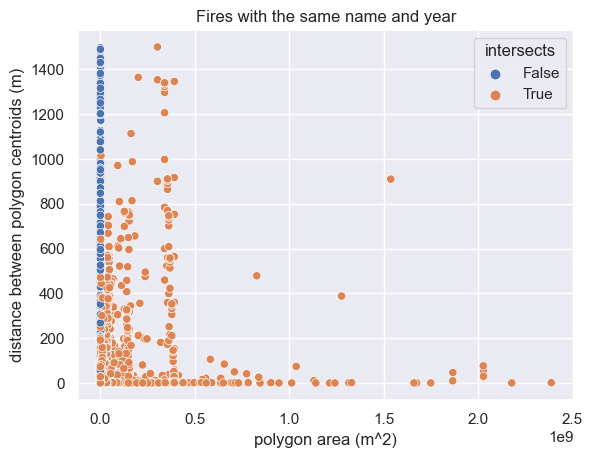

In [25]:
dist_analysis_df = pd.DataFrame(list(zip(areas, distances, intersections, diff)), columns=["area", "distance", "intersects", "difference"])
sns.set_theme(style="darkgrid")


g = sns.scatterplot(x="area", y="distance", hue="intersects", data=dist_analysis_df, color="b").set(title="Fires with the same name and year", xlabel="polygon area (m^2)", ylabel="distance between polygon centroids (m)")

In [26]:
fires_df_pass1 = gpd.GeoDataFrame(fires_list_pass1)
print("Pass 1 dedupped from {} to {} rows".format(len(all_fires_df.index), len(fires_df_pass1.index)))

Pass 1 dedupped from 83430 to 77362 rows


In [27]:
# pass 2 combination 
fire_groups_pass2 = find_fire_groups_different_names(fires_df_pass1)

fires_list_pass2 = []
for _, group in fire_groups_pass2:
    try:
        row = analyze_combine_group(group)
    except GroupError as e:
        print("ERROR: {}".format(e))
        continue
    fires_list_pass2.append(row)

Grouping similar fires, pass 2... |████████████████████████████████████████| 130


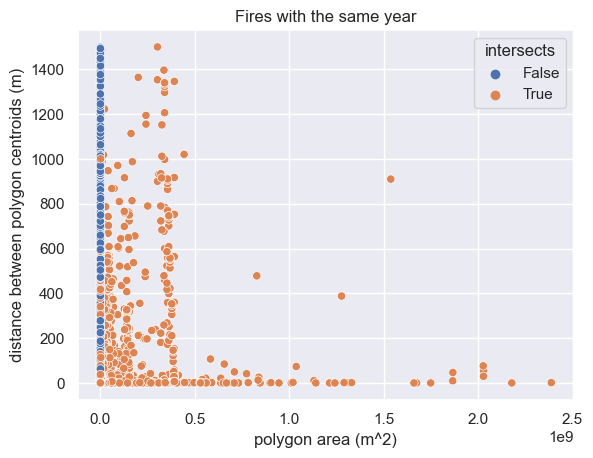

In [28]:
dist_analysis_df = pd.DataFrame(list(zip(areas, distances, intersections, diff)), columns=["area", "distance", "intersects", "difference"])

g = sns.scatterplot(x="area", y="distance", hue="intersects", data=dist_analysis_df, color="b").set(title="Fires with the same year", xlabel="polygon area (m^2)", ylabel="distance between polygon centroids (m)")

In [29]:
fires_df_pass2 = gpd.GeoDataFrame(fires_list_pass2)
print("Pass 2 dedupped from {} to {} rows".format(len(fires_df_pass1.index), len(fires_df_pass2.index)))

Pass 2 dedupped from 77362 to 76257 rows


In [31]:
# Create a df ready to export as a shapefile.

out_df = fires_df_pass2.copy()

# final cleanup, convert area to acres
out_df['AREA'] = out_df['AREA'] * 0.0002471054
out_df['YEAR'] = out_df['YEAR'].astype(int)


# export to shapefile does not handle GeometryDtype
out_df = out_df.drop(columns=['CENTROID'])

# set projection so can properly save geometry
out_df.set_crs("EPSG:4326", inplace=True)

# Convert dataframe to shapefile to analyze in QGIS.
out_df.to_file("data/fires.shp", driver='ESRI Shapefile')